In [1]:
import xarray as xr
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sqlalchemy import create_engine, inspect
from sklearn.neighbors import NearestNeighbors
from pprint import pprint

## 1. Reading and understanding the data

#### 1.0. Inspecting table metadata



In [2]:
# load db from file
engine = create_engine('sqlite:////content/exampleco_db.db', echo=False)

In [3]:
# inspect table names
inspector = inspect(engine)
inspector.get_table_names()

['feat_0', 'feat_1', 'feat_2', 'feat_3', 'static_data']

In [4]:
# inspect table column
inspector.get_columns('feat_1')

[{'autoincrement': 'auto',
  'default': None,
  'name': 'timestamp',
  'nullable': False,
  'primary_key': 1,
  'type': DATETIME()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'machine',
  'nullable': False,
  'primary_key': 2,
  'type': VARCHAR(length=9)},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'value',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]

#### 1.1 Inspecting table records

Executing a few sample queries to see how data in a table looks like:

In [5]:
# sample query to inspect feat_n table
query = "SELECT * FROM feat_0 LIMIT 10;"
query_out = engine.execute(query).fetchall()
pd.DataFrame(query_out[:5], columns=["timestamp","machine","value"])

,timestamp,machine,value
0,2019-01-01 00:00:00.000000000,machine_0,12.626096
1,2019-01-01 08:00:09.603201067,machine_0,10.831994
2,2019-01-01 16:00:19.206402134,machine_0,21.083510
3,2019-01-02 00:00:28.809603201,machine_0,32.294495
4,2019-01-02 08:00:38.412804268,machine_0,28.057100


In [9]:
# sample query to inspect static_data table
query = "SELECT * FROM static_data;"
query_out = engine.execute(query).fetchall()
pd.DataFrame(query_out, columns=["machine", "install_date", "model", "room"]).head()

,machine,install_date,model,room
0,machine_0,2019-01-01,Model A,Room 123
1,machine_1,2019-01-01,Model A,Room 123
2,machine_2,2019-01-01,Model A,Room 123
3,machine_3,2019-01-01,Model A,Room 123
4,machine_4,2019-01-01,Model A,Room 123


In [10]:
# inspect number of records for each table
def count_records(table):
  query = f"SELECT * FROM {table};"
  return len(engine.execute(query).fetchall())

tables = inspector.get_table_names()
print("Number of records per table:")
print({f"{table}": count_records(table) for table in tables})

Number of records per table:
{'feat_0': 60000, 'feat_1': 60000, 'feat_2': 60000, 'feat_3': 60000, 'static_data': 20}


I see that each *feat_n* table has 60000 records, and *static_data* has 20 records, 

#### 1.2. Distribution of records per machine

Knowing there are 20 machines (machine_0, machine_1,...,machine_19), I try to find out the distribution of records per machine in each table. To do this, I execute a query that groups records by *machine_id* for each table and count number of records per machine_id.  

In [11]:
# qeury that joins all feat_n tables and counts number of records for each machine
query = """
            SELECT machine, COUNT(feat_0_machine), COUNT(feat_1_machine),
                    COUNT(feat_2_machine),COUNT(feat_3_machine) 
            FROM
              (SELECT feat_0.timestamp as timestamp, feat_0.machine as machine,
              feat_0.machine as feat_0_machine, 
              feat_1.machine as feat_1_machine, 
              feat_2.machine as feat_2_machine,
              feat_3.machine as feat_3_machine
              FROM (((feat_0 
              INNER JOIN feat_1
              ON feat_0.timestamp=feat_1.timestamp AND feat_0.machine=feat_1.machine)
              INNER JOIN feat_2
              ON feat_1.timestamp=feat_2.timestamp AND feat_1.machine=feat_2.machine)
              INNER JOIN feat_3
              ON feat_2.timestamp=feat_3.timestamp AND feat_2.machine=feat_3.machine))
            GROUP BY machine;
        """
query_out = engine.execute(query).fetchall()
query_out_pd = pd.DataFrame(query_out, columns=["machine"]+[f"feat_{n}" for n in range(0,4)])
print("Number of records per machine:")
print(query_out_pd)

Number of records per machine:
       machine  feat_0  feat_1  feat_2  feat_3
0    machine_0    3000    3000    3000    3000
1    machine_1    3000    3000    3000    3000
2   machine_10    3000    3000    3000    3000
3   machine_11    3000    3000    3000    3000
4   machine_12    3000    3000    3000    3000
5   machine_13    3000    3000    3000    3000
6   machine_14    3000    3000    3000    3000
7   machine_15    3000    3000    3000    3000
8   machine_16    3000    3000    3000    3000
9   machine_17    3000    3000    3000    3000
10  machine_18    3000    3000    3000    3000
11  machine_19    3000    3000    3000    3000
12   machine_2    3000    3000    3000    3000
13   machine_3    3000    3000    3000    3000
14   machine_4    3000    3000    3000    3000
15   machine_5    3000    3000    3000    3000
16   machine_6    3000    3000    3000    3000
17   machine_7    3000    3000    3000    3000
18   machine_8    3000    3000    3000    3000
19   machine_9    3000    300

The result shows that indeed each of the four *feat_n* table has 3000 records each for each machine: 



({N}\{feat_n}/{N{machines}} ) x 20 = 3000


#### 1.3. Records  of timestamps

Knowing this, I try to find out if $timestamp$ for each of the 3000 records per *machine* *per*$ table {feat_0,...,feat_3}) is **unique**. I simply run a similar query as above, but this time count the number of distinct timestamps.

In [13]:
      
query = """
            SELECT machine, COUNT(DISTINCT(timestamp))
            FROM
              (SELECT feat_0.timestamp as timestamp, feat_0.machine as machine,
              feat_0.machine as feat_0_machine, 
              feat_1.machine as feat_1_machine, 
              feat_2.machine as feat_2_machine,
              feat_3.machine as feat_3_machine
              FROM (((feat_0 
              INNER JOIN feat_1
              ON feat_0.timestamp=feat_1.timestamp AND feat_0.machine=feat_1.machine)
              INNER JOIN feat_2
              ON feat_1.timestamp=feat_2.timestamp AND feat_1.machine=feat_2.machine)
              INNER JOIN feat_3
              ON feat_2.timestamp=feat_3.timestamp AND feat_2.machine=feat_3.machine))
            GROUP BY machine;
        """
query_out = engine.execute(query).fetchall()
query_out_pd = pd.DataFrame(query_out, columns=["machine","records_per_timestamp"])
print("Number of timestamps per machine:")
print(query_out_pd)

Number of timestamps per machine:
       machine  records_per_timestamp
0    machine_0                   3000
1    machine_1                   3000
2   machine_10                   3000
3   machine_11                   3000
4   machine_12                   3000
5   machine_13                   3000
6   machine_14                   3000
7   machine_15                   3000
8   machine_16                   3000
9   machine_17                   3000
10  machine_18                   3000
11  machine_19                   3000
12   machine_2                   3000
13   machine_3                   3000
14   machine_4                   3000
15   machine_5                   3000
16   machine_6                   3000
17   machine_7                   3000
18   machine_8                   3000
19   machine_9                   3000


For each *feat_n* table, there is indeed 3000 distinct timestamps $\textit{per}$ $machine$. To prove this, we see that number of records per machines is always equal to number of unique timestamps per machine.

#### 1.4. Visualizing tables shema

Having gathered enough information about the data and tables, I visualize the data schema:


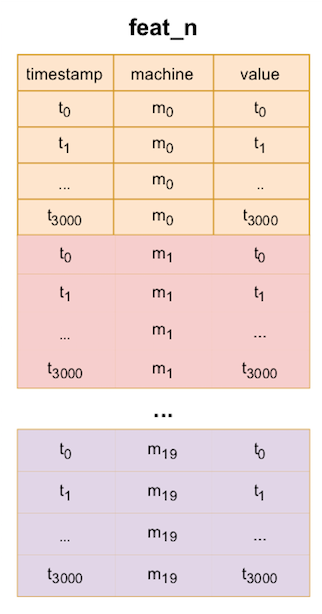

## 2. From SQL to Arrays

#### 2.1 Structure of array

Given the data schema, I decide to structure the arrays as follows:

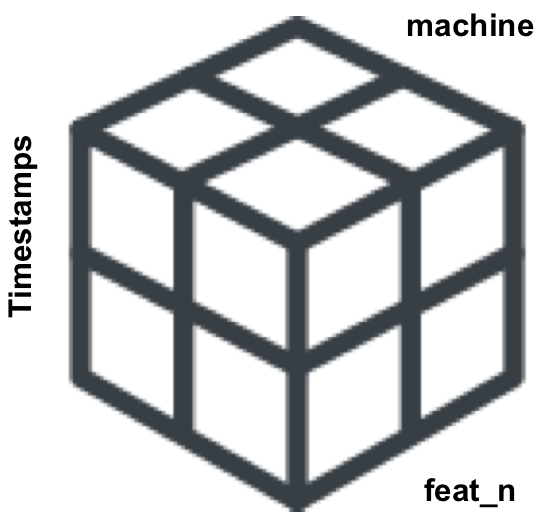

#### 2.2 Building the Array

To build the array, I first execute a SQL query that transposes a *feat_n* table into a table with columns {machine_0,machine_1,...,machine_19} and unique timestamps as labels. I use Python string formatting to reduce the length of the SQL query because SQL case statements would have made the SQL query very long. A transposed *feat_n* table looks like so:

In [26]:
query = "SELECT DISTINCT(machine) FROM feat_0"
machines = engine.execute(query).fetchall()
machines = [m[0] for m in machines]

def transpose_table(table):
  cases_str = ",".join([f"MAX(CASE WHEN machine='{m}' THEN value ELSE NULL END) AS {m}" for m in machines])
  machines_str = ",".join([m for m in machines])

  query = f"""
            SELECT {machines_str}
            FROM
            (SELECT *,
            {cases_str}
            FROM {table}
            GROUP BY timestamp);
          """
  
  table_pivot = engine.execute(query).fetchall()
  return table_pivot


In [27]:
feat_1_t = pd.DataFrame(transpose_table("feat_1")[:5], columns=machines)
print("A small selection of a transposed table:")
print(feat_1_t)

A small selection of a transposed table:
   machine_0   machine_1  machine_10  ...  machine_7  machine_8  machine_9
0   8.803120    8.829718    8.833675  ...   8.828701   8.825089   8.824018
1   2.816327    2.795246    2.805276  ...   2.774647   2.799094   2.802300
2  -0.672645   -0.655051   -0.652024  ...  -0.665288  -0.666184  -0.663752
3   6.525132    6.544655    6.540719  ...   6.530091   6.541520   6.542132
4   3.691359  253.681988    3.691273  ...   3.700640   3.712139   3.688309

[5 rows x 20 columns]


Starting with a 2-D Array of  𝑡𝑖𝑚𝑒𝑠𝑡𝑎𝑚𝑝  and  𝑚𝑎𝑐ℎ𝑖𝑛𝑒  values for each table, we then add  𝑓𝑒𝑎𝑡_𝑛  as the 3rd dimension. Next, I convert each transposed table into an a 2-Dimentional array, then $\textbf{stack}$ each 2-D array to create a 3-Dimentional array that I will use to create the DataArray. I use the np.stack() method that joins arrays along a new axis. The resulting 3-Day array will have the shape:

In [28]:
feat_tables_2d = [transpose_table(f"feat_{n}") for n in range(0,4)]
feat_3d = np.stack(feat_tables_2d,axis=1)
feat_3d.shape

(3000, 4, 20)

Now, I feed the 3-D Array into the xr.DataArray() method to create a DataArray() object. I pass the **dimensions** *feat_n*, *machine*, *timestamp* and **coordinates** as follows:

1.   **timestamps**: Unique timestamps {t_0,t_1,...,t_3000}
2.   **machines**: machine_id {machine\_1,machine_2,...,machine_19}
3.   **feat_n**: Each table containing data for each machine mode {feat_0,...,feat_3}



In [82]:
query = "SELECT DISTINCT(timestamp) FROM feat_0;"
timestamps = engine.execute(query).fetchall()
timestamps = [np.datetime64(t[0]) for t in timestamps]

feat_n = [f"feat_{n}" for n in range(0,4)]
 
data_array = xr.DataArray(feat_3d, dims=["timestamp", "feat_n", "machine"],
                          coords=[timestamps, feat_n, machines])

data_array

<xarray.DataArray (timestamp: 3000, feat_n: 4, machine: 20)>
array([[[ 1.26260963e+01,  1.25882427e+01,  1.26069586e+01, ...,
          1.26014441e+01,  1.26096243e+01,  1.26096621e+01],
        [ 8.80311979e+00,  8.82971843e+00,  8.83367515e+00, ...,
          8.82870081e+00,  8.82508916e+00,  8.82401841e+00],
        [-1.18092002e+01, -1.18034743e+01, -1.18000371e+01, ...,
         -1.17789565e+01, -1.18016882e+01, -1.17774411e+01],
        [ 1.00839611e+01,  1.00831070e+01,  1.00716606e+01, ...,
          1.00745013e+01,  1.00832413e+01,  1.00658185e+01]],

       [[ 1.08319940e+01,  1.08221991e+01,  1.08267655e+01, ...,
          1.08267373e+01,  1.08246895e+01,  1.08202473e+01],
        [ 2.81632702e+00,  2.79524611e+00,  2.80527639e+00, ...,
          2.77464696e+00,  2.79909374e+00,  2.80229951e+00],
        [ 1.15547777e+01,  1.15602785e+01,  1.15797987e+01, ...,
          1.15551890e+01,  1.15583429e+01,  1.15595986e+01],
        [ 2.18928529e+01,  2.18986883e+01,  2.18873850e+01, ...,
          2.18905889e+01,  2.19067400e+01,  2.18871918e+01]],

       [[ 2.10835100e+01,  2.10746607e+01,  2.10669142e+01, ...,
          2.10753628e+01,  2.10790244e+01,  2.10762442e+01],
...
        [ 1.33353510e-03, -1.58326141e-02, -2.38466581e-03, ...,
         -1.12406955e-02,  1.42070774e-03, -1.07808817e-04]],

       [[-8.14889505e-03, -8.98331569e-04,  2.89522974e-02, ...,
          1.16951676e-02,  3.63798334e-03,  7.19238935e-03],
        [ 1.06699123e-04, -1.12207178e-02, -1.13326338e-02, ...,
         -6.31221653e-03,  7.55065882e-03, -1.40555213e-02],
        [-1.79136023e-02, -3.78450394e-03, -1.40427828e-02, ...,
         -1.03047168e-02,  1.35202668e-02, -3.62745674e-03],
        [ 1.05985085e-02, -1.09635534e-02, -2.33860203e-03, ...,
          4.44945471e-03, -1.01793992e-03, -5.05073609e-03]],

       [[ 3.46456575e-03,  6.09198916e-03, -1.26129641e-03, ...,
         -1.08379010e-02, -1.11718572e-03,  7.09267877e-03],
        [ 2.34505331e-02,  6.97906099e-03,  3.78448958e-03, ...,
         -1.73162045e-03, -1.25780707e-02, -3.17024113e-03],
        [ 1.24631204e-02, -1.93786599e-02,  1.16592853e-02, ...,
          1.96100996e-03,  3.48245541e-04,  1.95888288e-03],
        [ 1.39967330e-02,  1.48875976e-02, -3.46509196e-04, ...,
          8.30916039e-03,  3.26712874e-03,  6.50225004e-03]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2019-01-01 ... 2021-09-27
  * feat_n     (feat_n) <U6 'feat_0' 'feat_1' 'feat_2' 'feat_3'
  * machine    (machine) <U10 'machine_0' 'machine_1' ... 'machine_9'

#### 2.3. Filtering outliers

Upon doing some manual explanatory data analysis, I decide use my intuition to filter outlier values that lie outside the ≈97.5th percentile. I decide not to impute NAs from outliers, and instead leave them as missing.

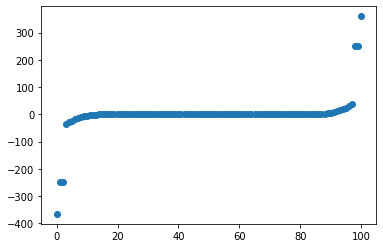

In [83]:
quantiles =[data_array.quantile(i*0.01).values.item() for i in range(0,101)]
plt.scatter([i for i in range(0,101)],quantiles)

Text(0, 0.5, 'value')

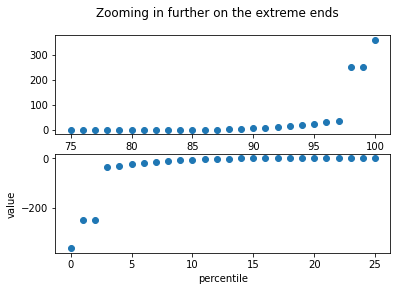

In [84]:
quantiles0 =[data_array.quantile(i*0.01).values.item() for i in range(0,26)]
quantiles1 =[data_array.quantile(i*0.01).values.item() for i in range(75,101)]

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Zooming in further on the extreme ends')
ax2.scatter([i for i in range(0,26)],quantiles0)
ax1.scatter([i for i in range(75,101)],quantiles1)
plt.xlabel("percentile")
plt.ylabel("value")

I see that there's a drastic spike in the ≈ 97.5th pecentile, so I chose it as my threshold cutoff.

In [85]:
def outliers(data_arr, perc=0.975):
  # threshold valye
  threshold = data_arr.quantile(perc)

  # replacing threshold as missing
  mask = data_arr.where(abs(data_arr) <= threshold)
  return mask


And now, after filtering out some outliers, some sample plots:

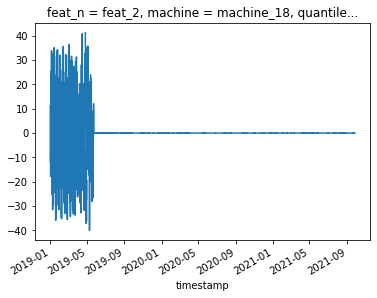

In [86]:
outliers(data_array[:,2])[:,10].plot()

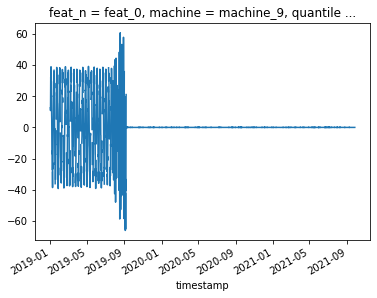

In [87]:
outliers(data_array[:,0])[:,19].plot()

#### 2.4. Static data

Instead of integrating the *static_data* to the DataArray, I instead decide to add it as metadata attributes for the $machine$ coordinate since it primarily contains information primarily for machines that's simply way too static. I'll add the static_data metadata in the form of a dictionary.

In [90]:
query = "SELECT * FROM static_data;"
query_out = engine.execute(query).fetchall()
static_data = pd.DataFrame(query_out, columns=["machine", "install_date", "model", "room"])

In [91]:
data_array.timestamp.attrs["machine_static_data"] = static_data.to_dict()

#### 2.6 Uploading data to AWS S3

Since I do not have access to an AWS S3 account, I'll demonstrate how I would have written the DataArray to AWS S3 using the **s3fs** package, a Python  wrapper for **boto3** which is the official AWS SDK for Python:



```
import zarr
import s3fs

# AWS S3 path
s3_path = 's3://path/to/s3' 


# Initilizing S3 file system
s3_file = s3fs.S3FileSystem()
data_store = s3fs.S3Map(root=s3_path, s3=s3_file, check=False)

# convert to xr.DataSet() object
ds = data_array.to_dataset()

# Save to zarr
ds.to_zarr(store=data_store)

```

